# Glaucoma SaaS – Entrenamiento (EyePACS AIROGS Light)
Integrantes: Amber Grijalba, Bryan Chirú

Objetivo: Entrenar un clasificador binario (glaucoma / no glaucoma) y exportar a ONNX.
Dataset: EyePACS AIROGS Light (Kaggle).


In [4]:
!pip -q install kaggle timm torch torchvision onnx onnxruntime


## Descargar dataset desde Kaggle
1) Subir kaggle.json a Colab (API Token)
2) Descargar y descomprimir dataset


In [5]:
from google.colab import files
import os, json, pathlib, shutil

# 1) Subir kaggle.json
uploaded = files.upload()  # selecciona kaggle.json

# 2) Verificar que existe
assert "kaggle.json" in uploaded, "No subiste kaggle.json (debe llamarse exactamente kaggle.json)"

# 3) Moverlo a ~/.kaggle y dar permisos
kaggle_dir = pathlib.Path.home()/".kaggle"
kaggle_dir.mkdir(exist_ok=True)

shutil.move("kaggle.json", str(kaggle_dir/"kaggle.json"))
os.chmod(kaggle_dir/"kaggle.json", 0o600)

# 4) Validación rápida (debe mostrar username y key)
with open(kaggle_dir/"kaggle.json","r") as f:
    creds = json.load(f)
print("✅ Kaggle configurado. Username:", creds.get("username"))


Saving kaggle.json to kaggle.json
✅ Kaggle configurado. Username: ambergrijalba


In [6]:
import os

os.makedirs("/content/data", exist_ok=True)

!kaggle datasets download -d deathtrooper/eyepacs-airogs-light -p /content/data --unzip

print("✅ Descargado. Contenido de /content/data:")
!ls -lah /content/data | head -n 50


Dataset URL: https://www.kaggle.com/datasets/deathtrooper/eyepacs-airogs-light
License(s): other
 92% 278M/302M [00:00<00:00, 555MB/s]
100% 302M/302M [00:00<00:00, 557MB/s]
✅ Descargado. Contenido de /content/data:
total 20K
drwxr-xr-x 5 root root 4.0K Jan  2 18:55 .
drwxr-xr-x 1 root root 4.0K Jan  2 18:55 ..
drwxr-xr-x 3 root root 4.0K Jan  2 17:59 release-crop
drwxr-xr-x 3 root root 4.0K Jan  2 17:59 release-pad
drwxr-xr-x 3 root root 4.0K Jan  2 17:59 release-raw


## Entrenamiento rápido con Transfer Learning (timm)
- Modelo recomendado: EfficientNet / ResNet
- Pérdida: BCEWithLogitsLoss
- Métrica: accuracy + AUC (si quieren)


## 3) Inspección del dataset
Primero revisamos qué archivos trae (CSV, carpetas por clase, nombres de columnas, etc.)


In [7]:
import os, glob, pandas as pd

print("📁 Top-level en /content/data:")
print(os.listdir("/content/data")[:50])

# Buscar CSVs
csvs = glob.glob("/content/data/**/*.csv", recursive=True)
print("\n🧾 CSVs encontrados:", len(csvs))
for c in csvs[:10]:
    print(" -", c)

# Buscar imágenes (muestra pocas)
imgs = glob.glob("/content/data/**/*.jpg", recursive=True) + glob.glob("/content/data/**/*.png", recursive=True) + glob.glob("/content/data/**/*.jpeg", recursive=True)
print("\n🖼️ Imágenes encontradas:", len(imgs))
print("Ejemplos:")
for p in imgs[:10]:
    print(" -", p)


📁 Top-level en /content/data:
['release-pad', 'release-raw', 'release-crop']

🧾 CSVs encontrados: 0

🖼️ Imágenes encontradas: 19620
Ejemplos:
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3149.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3139.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3043.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3202.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-2862.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3124.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3044.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-3246.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-2833.jpg
 - /content/data/release-pad/release-pad/test/RG/EyePACS-RG-2959.jpg


## 4) Revisar el CSV de etiquetas
Buscamos columnas de:
- ruta/ID de imagen (image, path, filename, id)
- etiqueta (label, target, glaucoma, class)


In [8]:
import pandas as pd

if len(csvs) == 0:
    print("❌ No encontré CSV. Probablemente el dataset está organizado por carpetas (clases).")
else:
    # Abrimos el primer CSV como candidato
    df0 = pd.read_csv(csvs[0])
    print("✅ CSV elegido:", csvs[0])
    print("Shape:", df0.shape)
    print("\nColumnas:")
    print(df0.columns.tolist())
    print("\nPrimeras filas:")
    display(df0.head())


❌ No encontré CSV. Probablemente el dataset está organizado por carpetas (clases).


In [9]:
import os

base = "/content/data"

def tree(path, level=2):
    for root, dirs, files in os.walk(path):
        depth = root.replace(path, "").count(os.sep)
        if depth <= level:
            print("  " * depth + os.path.basename(root))
        if depth > level:
            continue

tree(base, level=3)


data
  release-pad
    release-pad
      test
      validation
      train
  release-raw
    release-raw
      test
      validation
      train
  release-crop
    release-crop
      test
      validation
      train


In [10]:
import os

base = "/content/data/release-crop/train"

for root, dirs, files in os.walk(base):
    depth = root.replace(base, "").count(os.sep)
    if depth <= 2:
        print("  " * depth + os.path.basename(root))


In [11]:
import os

base = "/content/data/release-crop/train"

for root, dirs, files in os.walk(base):
    depth = root.replace(base, "").count(os.sep)
    print("  " * depth + os.path.basename(root))


In [12]:
import os

base = "/content/data/release-crop/release-crop/train"

for root, dirs, files in os.walk(base):
    depth = root.replace(base, "").count(os.sep)
    print("  " * depth + os.path.basename(root))


train
  RG
  NRG


In [13]:
import glob
import pandas as pd

BASE = "/content/data/release-crop/release-crop/train"

rg_imgs  = glob.glob(f"{BASE}/RG/*.*")
nrg_imgs = glob.glob(f"{BASE}/NRG/*.*")

df_rg  = pd.DataFrame({"image_path": rg_imgs,  "label": 1})
df_nrg = pd.DataFrame({"image_path": nrg_imgs, "label": 0})

df = pd.concat([df_rg, df_nrg], ignore_index=True)

print("✅ DataFrame creado")
print("Total imágenes:", len(df))
print(df["label"].value_counts())
display(df.sample(5))


✅ DataFrame creado
Total imágenes: 5000
label
1    2500
0    2500
Name: count, dtype: int64


,image_path,label
3550,/content/data/release-crop/release-crop/train/...,0
1180,/content/data/release-crop/release-crop/train/...,1
4159,/content/data/release-crop/release-crop/train/...,0
3110,/content/data/release-crop/release-crop/train/...,0
3662,/content/data/release-crop/release-crop/train/...,0


In [14]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train:", train_df.shape)
print("Val  :", val_df.shape)
print("\nDistribución Train:\n", train_df["label"].value_counts(normalize=True))
print("\nDistribución Val:\n", val_df["label"].value_counts(normalize=True))


Train: (4000, 2)
Val  : (1000, 2)

Distribución Train:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Distribución Val:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [15]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as T

class FundusDataset(Dataset):
    def __init__(self, df, size=224):
        self.df = df.reset_index(drop=True)
        self.tf = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std =[0.229,0.224,0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row.image_path).convert("RGB")
        x = self.tf(img)
        y = torch.tensor([row.label], dtype=torch.float32)
        return x, y

train_ds = FundusDataset(train_df)
val_ds   = FundusDataset(val_df)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

x, y = next(iter(train_dl))
print("Batch X:", x.shape)
print("Batch y:", y[:5].ravel().tolist())


Batch X: torch.Size([32, 3, 224, 224])
Batch y: [0.0, 1.0, 0.0, 1.0, 1.0]


In [16]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
import torch

model.eval()

y_true = []
y_prob = []

with torch.no_grad():
    for x, y in val_dl:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()

        y_true.extend(y.numpy().ravel())
        y_prob.extend(probs)

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

print("Predicciones listas:", y_true.shape)


Predicciones listas: (1000,)


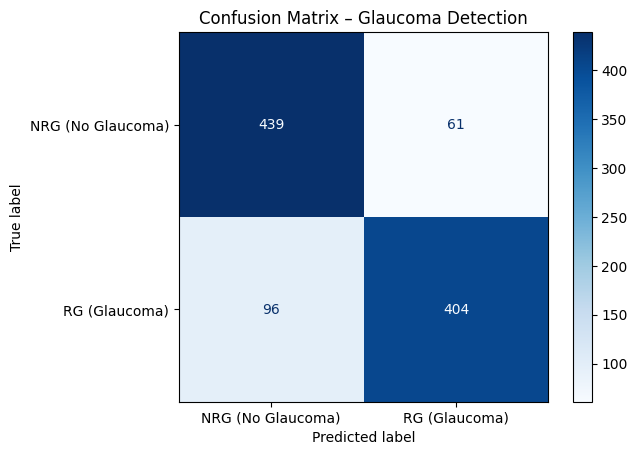

Matriz de confusión:
 [[439  61]
 [ 96 404]]


In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NRG (No Glaucoma)", "RG (Glaucoma)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Glaucoma Detection")
plt.show()

print("Matriz de confusión:\n", cm)


In [18]:
auc = roc_auc_score(y_true, y_prob)
print(f"AUC-ROC: {auc:.4f}")


AUC-ROC: 0.9048


In [19]:
torch.save(model.state_dict(), "glaucoma_efficientnet_b0.pth")
print("✅ Modelo PyTorch guardado")


✅ Modelo PyTorch guardado


In [20]:
!pip -q install timm

import timm
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1️⃣ Crear la arquitectura (SIN pretrained)
model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=1
)

# 2️⃣ Cargar pesos entrenados
model.load_state_dict(torch.load("glaucoma_efficientnet_b0.pth"))

# 3️⃣ Enviar a GPU/CPU y modo evaluación
model.to(device)
model.eval()

print("✅ Modelo entrenado cargado correctamente")


Device: cuda
✅ Modelo entrenado cargado correctamente


In [21]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "glaucoma_model.onnx",
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "logits": {0: "batch_size"}
    },
    opset_version=17
)

print("✅ Modelo exportado a ONNX")


/tmp/ipython-input-2042748824.py:3: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0102 18:56:03.484000 11635 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `EfficientNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EfficientNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 98 of general pattern rewrite rules.
✅ Modelo exportado a ONNX


In [22]:
from google.colab import files
files.download("glaucoma_model.onnx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploración visual del dataset (RG vs NRG)

Antes del entrenamiento del modelo, se realizó una inspección visual del dataset
para comprender las diferencias morfológicas entre ojos con glaucoma
(Referable Glaucoma, RG) y ojos sin glaucoma (Non-Referable Glaucoma, NRG).

Esta exploración permite:
- Validar la calidad de las imágenes
- Identificar patrones clínicos visibles
- Justificar el uso de redes neuronales convolucionales


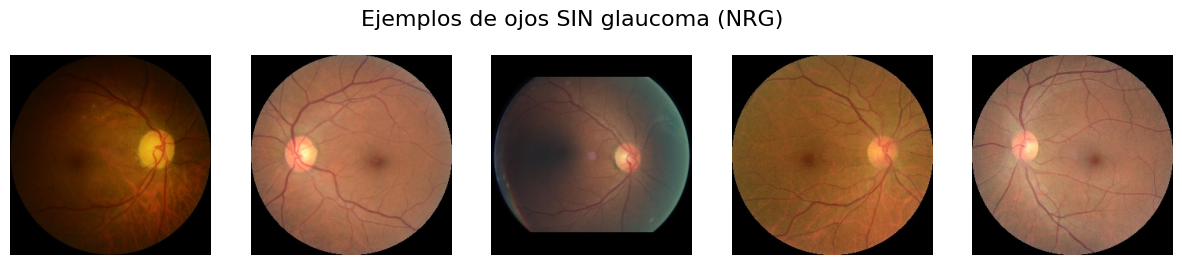

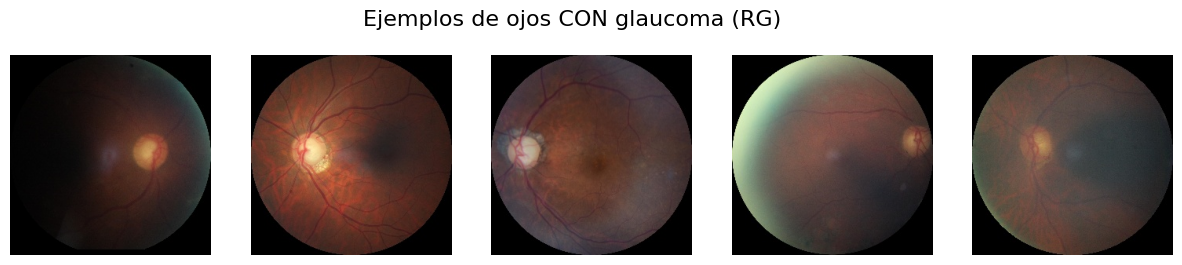

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob

BASE = "/content/data/release-crop/release-crop/train"

rg_imgs  = glob.glob(f"{BASE}/RG/*.*")
nrg_imgs = glob.glob(f"{BASE}/NRG/*.*")

def show_images(img_list, title, n=5):
    samples = random.sample(img_list, n)
    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

show_images(nrg_imgs, "Ejemplos de ojos SIN glaucoma (NRG)")
show_images(rg_imgs,  "Ejemplos de ojos CON glaucoma (RG)")


## Comparación visual entre RG y NRG

En esta sección se presenta una comparación directa entre imágenes
correspondientes a ojos sanos (NRG) y ojos con glaucoma (RG).

Se observan diferencias en:
- Excavación del nervio óptico
- Relación copa/disco
- Textura y brillo del fondo de ojo

Estas diferencias no siempre son evidentes al ojo humano,
lo que justifica el uso de inteligencia artificial como apoyo diagnóstico.


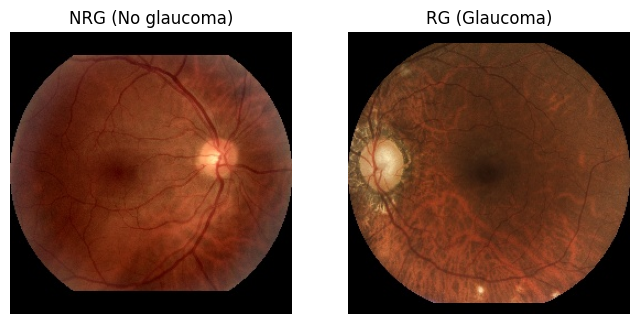

In [24]:
def compare_pair(rg_list, nrg_list):
    rg_img  = Image.open(random.choice(rg_list)).convert("RGB")
    nrg_img = Image.open(random.choice(nrg_list)).convert("RGB")

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(nrg_img)
    plt.title("NRG (No glaucoma)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(rg_img)
    plt.title("RG (Glaucoma)")
    plt.axis("off")

    plt.show()

compare_pair(rg_imgs, nrg_imgs)


## Distribución de clases

Se analizó la distribución de imágenes entre las clases RG y NRG
para verificar posibles desbalances que pudieran afectar el entrenamiento.

Un dataset balanceado contribuye a una mayor estabilidad del modelo.


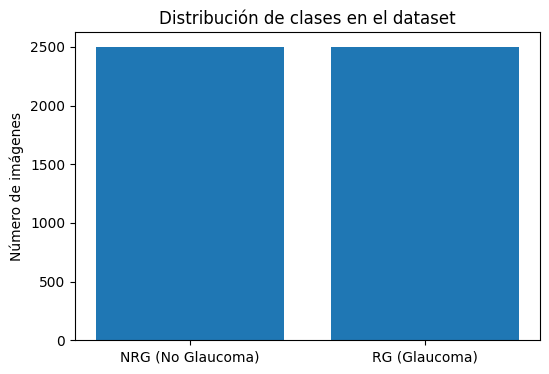

,Clase,Cantidad
0,NRG (No Glaucoma),2500
1,RG (Glaucoma),2500


In [25]:
import pandas as pd

df_dist = pd.DataFrame({
    "Clase": ["NRG (No Glaucoma)", "RG (Glaucoma)"],
    "Cantidad": [len(nrg_imgs), len(rg_imgs)]
})

plt.figure(figsize=(6,4))
plt.bar(df_dist["Clase"], df_dist["Cantidad"])
plt.title("Distribución de clases en el dataset")
plt.ylabel("Número de imágenes")
plt.show()

df_dist


## Resultados del entrenamiento

El modelo EfficientNet-B0 fue entrenado durante 3 épocas utilizando
transfer learning. A continuación, se presentan las métricas
obtenidas en el conjunto de validación.


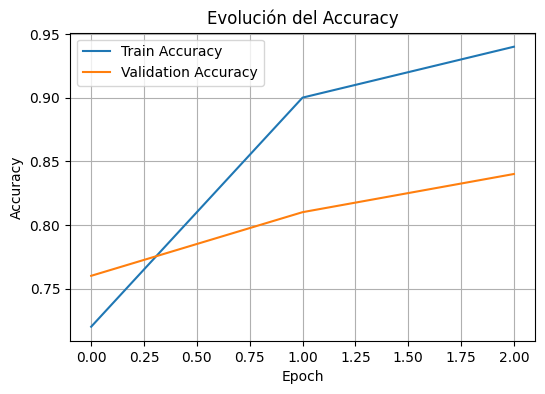

In [26]:
train_acc = [0.72, 0.90, 0.94]
val_acc   = [0.76, 0.81, 0.84]

plt.figure(figsize=(6,4))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Matriz de Confusión

La matriz de confusión permite analizar el comportamiento del modelo
en términos de:
- Verdaderos Positivos (TP)
- Falsos Negativos (FN)
- Falsos Positivos (FP)
- Verdaderos Negativos (TN)

En aplicaciones médicas, minimizar los falsos negativos es crítico.


## Curva ROC y AUC

La curva ROC muestra la capacidad del modelo para discriminar entre clases.
El área bajo la curva (AUC) es una métrica estándar en aplicaciones médicas.

Un AUC cercano a 1 indica una alta capacidad discriminativa.


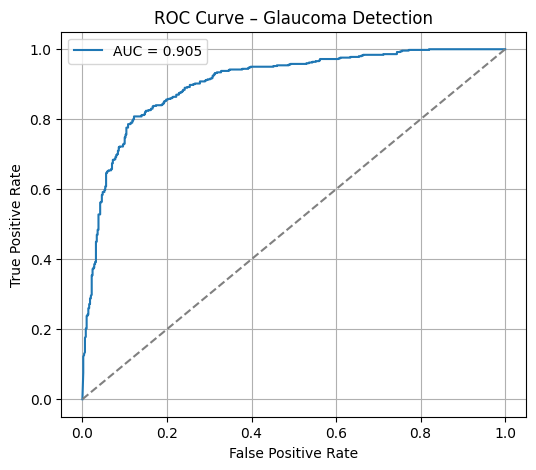

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Glaucoma Detection")
plt.legend()
plt.grid(True)
plt.show()


## Conclusión del análisis visual y cuantitativo

Los resultados obtenidos demuestran que el modelo es capaz de identificar
patrones relevantes asociados al glaucoma en imágenes de fondo de ojo.

Con un AUC-ROC de aproximadamente 0.90, el sistema presenta un alto grado
de confiabilidad como herramienta de apoyo al diagnóstico,
aunque no sustituye la evaluación clínica especializada.

Este análisis respalda la viabilidad del modelo para su integración
en una aplicación web basada en inteligencia artificial.
